In [3]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE

In [4]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, label_df = utils.load_features(
    data_dir,
    exclude_features=["is_dna", "num_seqs", "seq_length"],
)
clean_feat_names = feat_df.columns.str.replace(":", ".").to_list()
feat_df.columns = clean_feat_names

print(feat_df.shape)
print(drop_df.shape)
print(label_df.shape)

Dropping 0 NaN rows...
(11431, 469)
(11431, 21)
(11431, 1)


In [147]:
# # TEST PERFORMANCE ON WITHHELD DATA
# excluded = "bali3"
# excl_idxs = feat_df.query(f"source == '{excluded}'").index.copy()
# excl_feats = feat_df.loc[excl_idxs].copy()
# excl_labels = label_df.loc[excl_idxs].copy()
# feat_df = feat_df.drop(excl_idxs, axis=0)
# label_df = label_df.drop(excl_idxs, axis=0)
# print(feat_df.shape)
# print(drop_df.shape)
# print(label_df.shape)

In [148]:
# print("max num seqs", drop_df["num_seqs"].max())
# print("max seq len", drop_df["max:seq_length"].max())

In [5]:
from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(
    feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
)
test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
print(len(train_idxs), len(test_idxs), len(valid_idxs))

X_train = feat_df.loc[train_idxs]
X_test = feat_df.loc[test_idxs]
X_valid = feat_df.loc[valid_idxs]
y_train = label_df.loc[train_idxs].iloc[:, 0]
y_test = label_df.loc[test_idxs].iloc[:, 0]
y_valid = label_df.loc[valid_idxs].iloc[:, 0]

9144 1143 1144


In [6]:
param_df = pd.read_parquet(ROOT / "optuna" / "trial_03.parquet")
param_df.head(10)

,score,n_jobs,objective,metric,n_estimators,verbosity,bagging_fraction,learning_rate,subsample,colsample_bytree,feature_fraction_bynode,min_data_in_leaf,num_leaves
0,0.045414,1,regression,rmse,2000,-1,0.406860,0.029181,0.782712,0.138784,0.225888,24,39
1,0.045493,1,regression,rmse,2000,-1,0.370978,0.021477,0.621130,0.150053,0.170774,25,44
2,0.045512,1,regression,rmse,2000,-1,0.347928,0.023625,0.613847,0.129133,0.196989,24,45
3,0.045539,1,regression,rmse,2000,-1,0.366280,0.021108,0.622860,0.077859,0.449930,25,44
4,0.045539,1,regression,rmse,2000,-1,0.660120,0.023545,0.624443,0.157915,0.076476,24,43
5,0.045551,1,regression,rmse,2000,-1,0.371277,0.021348,0.600807,0.150279,0.172101,25,44
6,0.045559,1,regression,rmse,2000,-1,0.330793,0.017749,0.650272,0.134044,0.178739,23,43
7,0.045564,1,regression,rmse,2000,-1,0.433394,0.019313,0.627293,0.120334,0.187564,30,45
8,0.045564,1,regression,rmse,2000,-1,0.673654,0.024573,0.604955,0.086559,0.502934,28,45
9,0.045579,1,regression,rmse,2000,-1,0.680105,0.024880,0.716180,0.122105,0.260099,20,44


In [7]:
import lightgbm as lgb

param_df = pd.read_parquet(ROOT / "optuna" / "trial_03.parquet")
params = dict(param_df.drop("score", axis=1).iloc[0])
print(params)
for key, val in params.items():
    if isinstance(params[key], float) and (float(int(val)) == val):
        params[key] = int(val)
# Train the model
model = lgb.LGBMRegressor(**params)
model = model.fit(X_train, y_train)

{'n_jobs': np.int64(1), 'objective': 'regression', 'metric': 'rmse', 'n_estimators': np.int64(2000), 'verbosity': np.int64(-1), 'bagging_fraction': np.float64(0.4068601746586925), 'learning_rate': np.float64(0.029181354675432546), 'subsample': np.float64(0.7827119580626293), 'colsample_bytree': np.float64(0.13878437450629255), 'feature_fraction_bynode': np.float64(0.2258881395363993), 'min_data_in_leaf': np.int64(24), 'num_leaves': np.int64(39)}


In [8]:
y_pred = model.predict(feat_df.loc[valid_idxs])
y_true = label_df.loc[valid_idxs].to_numpy().ravel()
# mask = y_true > 0.1
# y_pred = y_pred[mask]
# y_true = y_true[mask]

# y_pred = model.predict(dnaf_feats)
# y_true = dnaf_labels.to_numpy().ravel()

In [14]:
eps = 1e-2
perf_df = utils.compute_metrics(model, X_valid, y_valid, eps)
print(perf_df)
print()
print(np.sort(np.abs(y_pred - y_true) / (y_true + eps))[::-1][:20])

     RMSE RMSE_CV     MAE    MAPE MAPE_P50    CORR
0  0.0407  0.2797  0.0249  0.2518   0.1623  0.9738

[4.92624192 3.06385343 2.46508334 2.27576086 2.20810539 2.15839004
 1.99653556 1.86456183 1.80130148 1.78201349 1.62733909 1.61261508
 1.59383809 1.57861805 1.5499974  1.54382205 1.53076348 1.36823621
 1.3484653  1.32545918]


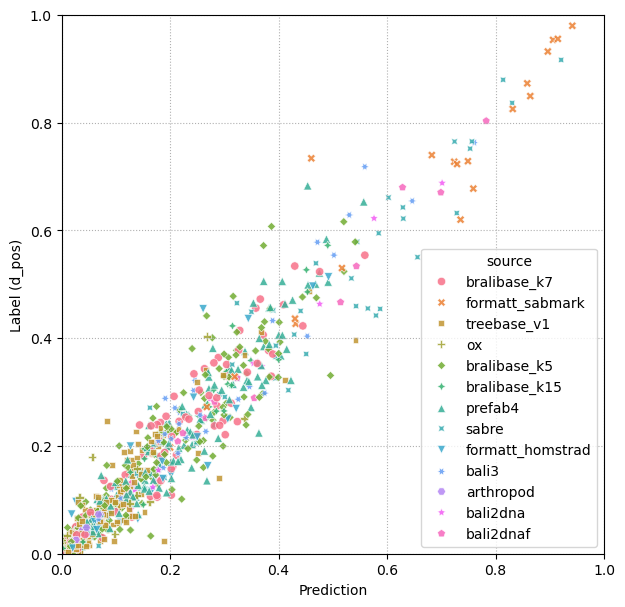

In [12]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[valid_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 7))
sn.scatterplot(x=y_pred, y=y_true, alpha=0.85, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

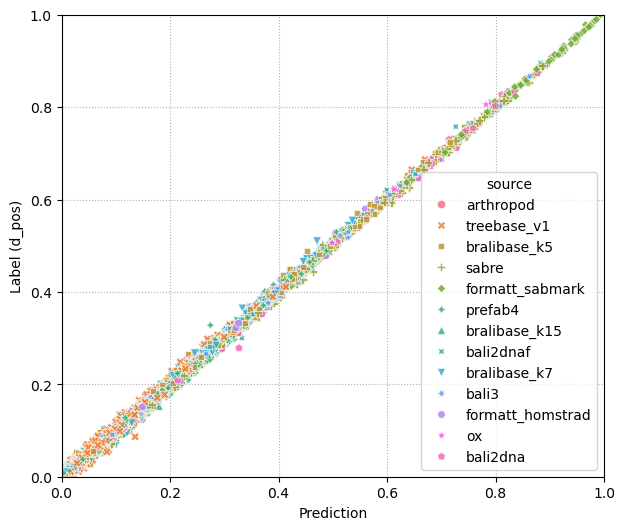

In [13]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[train_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 6))
sn.scatterplot(
    x=model.predict(feat_df.loc[train_idxs]),
    y=label_df.loc[train_idxs].to_numpy().ravel(),
    alpha=0.85,
    style=sources,
    hue=sources,
)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

In [67]:
test = feat_df.copy()
test["label"] = label_df["mean"]
corr = test.corr().loc["label"]
corr = corr.iloc[corr.abs().argsort()[::-1]]
corr[:20]

label                1.000000
p70:tc_base_p50     -0.884982
p70:tc_base_mean    -0.883522
p70:tc_base_min     -0.882288
p60:tc_base_p50     -0.881221
p70:tc_base_max     -0.880806
mean:tc_base_p50    -0.880683
p60:tc_base_mean    -0.880377
mean:tc_base_mean   -0.879720
mean:tc_base_max    -0.879586
p60:tc_base_max     -0.879580
p60:tc_base_min     -0.878223
mean:tc_base_min    -0.877962
p50:tc_base_max     -0.873647
p50:tc_base_p50     -0.873623
p50:tc_base_mean    -0.873135
p80:tc_base_p50     -0.872902
p80:tc_base_min     -0.870997
p50:tc_base_min     -0.870647
p80:tc_base_mean    -0.870593
Name: label, dtype: float64

In [17]:
imps = model.feature_importances_
imps


# else:
imps = model.feature_importances_
imp_df = pd.DataFrame(dict(feature=feat_df.columns, importance=imps))
imp_df = imp_df.sort_values("importance", ignore_index=True, ascending=False)
imp_df[:10]
imp_df[imp_df.feature.str.contains("mer")].iloc[:10]
imp_df
# np.save(ROOT / "top_feats.npy", imp_df.feature[:50].to_numpy())

,feature,importance
0,lower_bound_gap_percentage,712
1,iqr.9mer_ent,474
2,std.psa_score_ratio,432
3,std.frst_mean,421
4,iqr.7mer_ent,416
...,...,...
464,p50.psa_gap_len_logdiff,0
465,min.psa_gap_len_logdiff,0
466,p1.psa_gap_len_logdiff,0
467,p5.psa_gap_len_logdiff,0


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

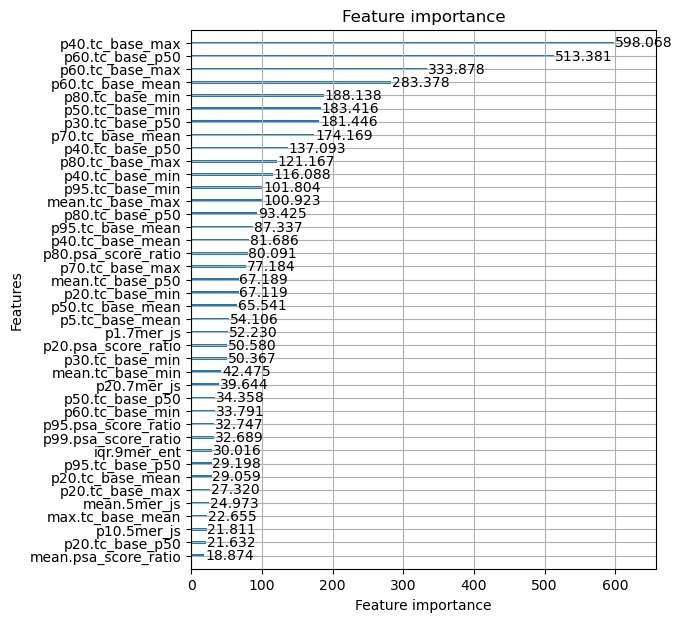

In [14]:
lgb.plot_importance(model, figsize=(6, 7), importance_type="gain", max_num_features=40)
# else:
#     pass
# sn.barplot(x=feat, y=importance[sort_idxs], hue=is_tc)
# ax = plt.gca()
# _ = ax.set_xticklabels([])
# _ = ax.legend(title="Consistency-based")
# _ = ax.set_ylabel("Feature importance")
# _ = ax.set_xlabel("Features")
# print(top_feats[:30])

In [177]:
label_df.sort_values("mean", ascending=False).tail(40)
test_df = label_df.copy().reset_index()
test_df["iszero"] = test_df["mean"] == 0
test_df.groupby(["source"]).mean(numeric_only=True)

,mean,iszero
source,,
arthropod,0.042027,0.000000
bali2dna,0.422209,0.000000
bali2dnaf,0.424904,0.000000
bali3,0.299184,0.000000
bralibase_k15,0.123918,0.262425
bralibase_k5,0.145104,0.290229
bralibase_k7,0.137546,0.285414
formatt_homstrad,0.161023,0.033742
formatt_sabmark,0.740137,0.000000
